In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd 
data = pd.read_pickle("/content/gdrive/MyDrive/final_text_df.pkl")

### Data with 20K+ news.

In [ ]:
data.head(2)

,main_img_url,text,title,type,caps_title,caps_thread,caps_text,title_len,thread_len,text_len,excl_title,excl_thread,excl_text,first_title,first_thread,first_text,second_title,second_thread,second_text,third_title,third_thread,third_text,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,negative,positive,first_all,second_all,third_all
0,https://static01.nyt.com/images/2016/11/23/us/...,"[917, 201, 997, 1132, 13667, 637, 125, 3367, 1...","[425, 14744, 18652, 71, 10303, 30, 14538, 18, ...",0.0,0,0,0,74,1,6489,0,0,0,2,0,407,0,0,150,0,0,45,9,21,5,6,20,5,14,30,14,52,409,150,45
1,https://static01.nyt.com/images/2016/10/18/us/...,"[14744, 216, 18652, 71, 10303, 30, 6257, 4603,...","[18652, 6257, 14327, 414, 1286, 1183, 6099, 13...",0.0,0,0,0,75,1,2163,0,0,0,5,0,140,0,0,38,2,0,26,6,7,2,4,4,4,5,9,8,15,145,38,28


In [ ]:
data.shape

(20015, 35)

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import style
style.use('seaborn')
import seaborn as sns
from tensorflow import keras as k
from sklearn.model_selection import train_test_split
from gensim.models import KeyedVectors
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [ ]:
len_content = len(data['text'][0])
len_title = len(data['title'][0])

### using glove embeddings

In [ ]:
from pathlib import Path
import numpy as np
from keras.preprocessing.text import Tokenizer

def load_glove(url):
    f = open(url.absolute())
    embeddings_index = dict()
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype="float32")
        embeddings_index[word] = coefs
    f.close()
    return embeddings_index

GLOVE_URL = Path("/content/gdrive/MyDrive/glove.6B.100d.txt")
glove = load_glove(GLOVE_URL)
t = Tokenizer()
t.fit_on_texts(glove.keys())
vocab_size = (len(t.word_index)+1)
#+1 for out of vocabulary words.

In [ ]:
vocab_size

339252

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences


df=pd.DataFrame()
df["text"] = (pad_sequences(data["text"], maxlen=400,padding="post", truncating="post")).tolist()
df["title"] = pad_sequences(data["title"], maxlen=400,padding="post", truncating="post").tolist()

In [ ]:
df.head()

,text,title
0,"[917, 201, 997, 1132, 13667, 637, 125, 3367, 1...","[425, 14744, 18652, 71, 10303, 30, 14538, 18, ..."
1,"[14744, 216, 18652, 71, 10303, 30, 6257, 4603,...","[18652, 6257, 14327, 414, 1286, 1183, 6099, 13..."
2,"[137, 26436, 13531, 201, 2403, 6098, 3367, 324...","[14744, 18652, 17853, 142, 266, 582, 6138, 135..."
3,"[1289, 137, 1610, 16006, 1301, 13949, 13533, 1...","[29208, 640, 13636, 13531, 18652, 71, 10303, 3..."
4,"[997, 1132, 14744, 216, 18652, 71, 10303, 30, ...","[54038, 189, 27100, 18652, 2361, 71, 10303, 13..."


In [ ]:
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in t.word_index.items():
    embedding_vector = glove.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_matrix.shape

(339252, 100)

### Train-test-val split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df[['text', 'title']], data['type'], test_size=0.1, random_state=1)

#Train - valid
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.1, random_state=1)

In [ ]:
X_train_title = X_train['title']
X_train_content = X_train['text']

X_valid_title = X_valid['title']
X_valid_content = X_valid['text']

X_test_title = X_test['title']
X_test_content = X_test['text']

In [ ]:
train_fit = [np.asarray(X_train_title.tolist()), 
             np.asarray(X_train_content.tolist())]

valid_fit = [np.asarray(X_valid_title.tolist()), 
             np.asarray(X_valid_content.tolist())]

test_fit = [np.asarray(X_test_title.tolist()), 
             np.asarray(X_test_content.tolist())]

In [ ]:
import keras.backend as K

def f1(y_true, y_pred): #taken from old keras source code
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
  precision = true_positives / (predicted_positives + K.epsilon())
  recall = true_positives / (possible_positives + K.epsilon())
  f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
  return f1_val

In [ ]:
import tensorflow as tf
import os

from numpy.random import seed

In [ ]:

!pip install scikit-optimize

import skopt

from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt.plots import plot_objective

from numpy.random import seed


import tensorflow as tf

import os

     |████████████████████████████████| 102kB 4.5MB/s 


### Using model with bayesian optimization get  the optimal parameters.

In [ ]:
space  = [Real(1e-3, 0.4, name='lr'),
          Real(1e-3, 0.1, name='momentum'),
          Real(0.1, 0.3, name='dropout1'),
          Integer(50,100, name='dense1'),
          Integer(20,50, name='dense2'),
          Integer(20,100, name='GRUTitle'),
          Integer(50,300, name='GRUContent')]

In [ ]:
@use_named_args(space)
def lstm_model(**params):
    
    x_train = train_fit
    y_train2 = np.array(y_train.tolist())
    
    x_valid = valid_fit
    y_valid2 = np.array(y_valid.tolist())
    
    x_test = test_fit
    y_test2 = np.array(y_test.tolist())

    #Reproducible weights
    seed(50)
    tf.random.set_seed(50)
    k.backend.clear_session()
    
    #input_title
    title_input = k.layers.Input(shape=(400), name='title_input')
    inp = k.layers.Embedding(output_dim=100, input_dim=vocab_size, weights=[embedding_matrix], trainable=False)(title_input)
    x = k.layers.Bidirectional(k.layers.GRU(params['GRUTitle']))(inp)

    #input_content
    content_input = k.layers.Input(shape=(400), name='content_input')
    inp2 = k.layers.Embedding(output_dim=100, input_dim=vocab_size, weights=[embedding_matrix], trainable=False)(content_input)
    x2 = k.layers.Bidirectional(k.layers.GRU(params['GRUContent']))(inp2)
  
    #Merge
    x = k.layers.concatenate([x, x2])

    #Common part
    x = k.layers.Dense(params['dense1'], activation='relu')(x)
    x = k.layers.Dropout(params['dropout1'])(x)
    x = k.layers.Dense(params['dense2'], activation='relu')(x)
    x = k.layers.Dropout(0.2)(x)

    out = k.layers.Dense(1, activation='sigmoid')(x)

    #Build model
    model = k.models.Model(inputs=[title_input, content_input], outputs=[out])

    model.compile(optimizer =tf.keras.optimizers.Adam(learning_rate=0.00001,decay=0.0001),metrics=["accuracy",f1],loss= "binary_crossentropy")
    
    out = model.fit(x=train_fit, y=np.asarray(y_train.tolist()), batch_size=64, epochs=30,validation_data=(valid_fit, np.array(y_valid.tolist())))
  
    #Evaluation
    acc = model.evaluate(x=x_test, y=y_test2)
    return -acc[1] #Maximize accuracy

In [ ]:
r = skopt.gp_minimize(lstm_model, n_random_starts=3, n_calls=3, dimensions=space)

Epoch 1/30
254/254 [==============================] - 127s 356ms/step - loss: 0.6790 - accuracy: 0.5869 - f1: 0.7247 - val_loss: 0.6503 - val_accuracy: 0.6160 - val_f1: 0.7431
Epoch 2/30
254/254 [==============================] - 89s 351ms/step - loss: 0.6399 - accuracy: 0.6326 - f1: 0.7491 - val_loss: 0.6118 - val_accuracy: 0.6903 - val_f1: 0.7664
Epoch 3/30
254/254 [==============================] - 89s 352ms/step - loss: 0.6032 - accuracy: 0.6905 - f1: 0.7725 - val_loss: 0.5793 - val_accuracy: 0.7181 - val_f1: 0.7813
Epoch 4/30
254/254 [==============================] - 89s 351ms/step - loss: 0.5823 - accuracy: 0.6964 - f1: 0.7677 - val_loss: 0.5525 - val_accuracy: 0.7358 - val_f1: 0.7868
Epoch 5/30
254/254 [==============================] - 89s 350ms/step - loss: 0.5489 - accuracy: 0.7270 - f1: 0.7853 - val_loss: 0.5264 - val_accuracy: 0.7558 - val_f1: 0.8018
Epoch 6/30
254/254 [==============================] - 89s 350ms/step - loss: 0.5309 - accuracy: 0.7409 - f1: 0.7937 - val_lo

### Tuned parameters.

In [ ]:
print("PARAMETERS (LR/Optimizer): {}  RESULT {}".format(r.x, r.fun))

PARAMETERS (LR/Optimizer): [0.05254065915946037, 0.008363284128099065, 0.22198762654711296, 51, 25, 96, 251]  RESULT -0.8756243586540222


### Trained model with optimal parameters

In [ ]:
def precision(y_true,y_pred):
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
  prcsn = true_positives / (predicted_positives + K.epsilon())
  return prcsn

def recall(y_true,y_pred):
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
  rcll = true_positives / (possible_positives + K.epsilon())
  return rcll


def f1(y_true, y_pred): #taken from old keras source code
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
  precision = true_positives / (predicted_positives + K.epsilon())
  recall = true_positives / (possible_positives + K.epsilon())
  f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
  return f1_val

In [ ]:
title_input = k.layers.Input(shape=(400), name='title_input')
inp = k.layers.Embedding(input_dim=vocab_size,output_dim=100, weights=[embedding_matrix], trainable=False,)(title_input)
x = k.layers.Bidirectional(k.layers.GRU(96))(inp)

#input_content
content_input = k.layers.Input(shape=(400), name='content_input')
inp2 = k.layers.Embedding(output_dim=100, input_dim=vocab_size, weights=[embedding_matrix], trainable=False)(content_input)
x2 = k.layers.Bidirectional(k.layers.GRU(251))(inp2)

#Merge
x = k.layers.concatenate([x, x2])

#Common part
x = k.layers.Dense(51, activation='relu')(x)
x = k.layers.Dropout(0.222)(x)
x = k.layers.Dense(25, activation='relu')(x)
x = k.layers.Dropout(0.2)(x)

out = k.layers.Dense(1, activation='sigmoid')(x)

#Build model
model = k.models.Model(inputs=[title_input, content_input], outputs=[out])

model.compile(optimizer =tf.keras.optimizers.Adam(learning_rate=0.00001,decay=0.0001),metrics=[precision,recall, f1],loss= "binary_crossentropy")

### Callbacks

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint_path = "training_3/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
my_callbacks = [
ModelCheckpoint(checkpoint_path, monitor = 'val_loss',verbose = 1,save_weights_only=True, save_best_only = True,mode="min"),
EarlyStopping(monitor='val_loss', patience=3, verbose=0, mode='min'),
ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='min',min_delta=1e-4)]

### Model architechture

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
title_input (InputLayer)        [(None, 400)]        0                                            
__________________________________________________________________________________________________
content_input (InputLayer)      [(None, 400)]        0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 400, 100)     33925200    title_input[0][0]                
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 400, 100)     33925200    content_input[0][0]              
____________________________________________________________________________________________

### Model fitting

In [ ]:
out = model.fit(x=train_fit, y=np.asarray(y_train.tolist()), batch_size=64, epochs=30,validation_data=(valid_fit, np.array(y_valid.tolist())),callbacks=[my_callbacks])

Epoch 1/30
254/254 [==============================] - 98s 354ms/step - loss: 0.6764 - precision: 0.6656 - recall: 0.6332 - f1: 0.6418 - val_loss: 0.6446 - val_precision: 0.6641 - val_recall: 0.8265 - val_f1: 0.7336

Epoch 00001: val_loss improved from inf to 0.64459, saving model to training_3/cp.ckpt
Epoch 2/30
254/254 [==============================] - 88s 348ms/step - loss: 0.6372 - precision: 0.6855 - recall: 0.8146 - f1: 0.7419 - val_loss: 0.6130 - val_precision: 0.7056 - val_recall: 0.8083 - val_f1: 0.7491

Epoch 00002: val_loss improved from 0.64459 to 0.61298, saving model to training_3/cp.ckpt
Epoch 3/30
254/254 [==============================] - 89s 349ms/step - loss: 0.6104 - precision: 0.7090 - recall: 0.8147 - f1: 0.7560 - val_loss: 0.5858 - val_precision: 0.7125 - val_recall: 0.8395 - val_f1: 0.7669

Epoch 00003: val_loss improved from 0.61298 to 0.58581, saving model to training_3/cp.ckpt
Epoch 4/30
254/254 [==============================] - 88s 348ms/step - loss: 0.5898

### Saving model

In [ ]:
model.save("/content/gdrive/MyDrive/TIcnn-gru/model20k_400.h5")

### Precision curve

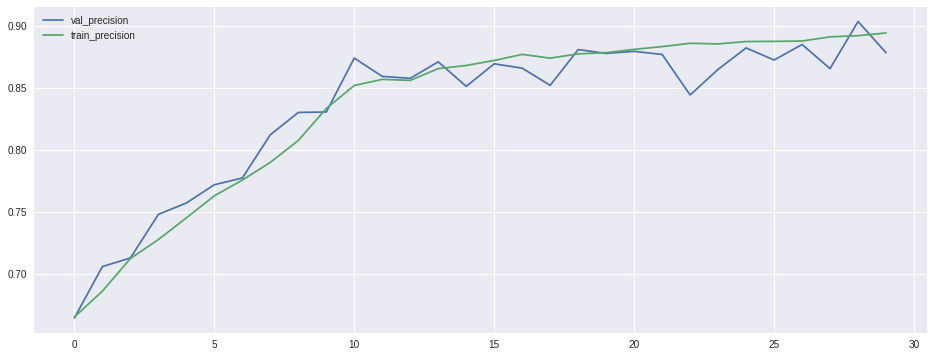

In [ ]:
plt.figure(figsize=(16,6))
plt.plot(out.history['val_precision'], label='val_precision')
plt.plot(out.history['precision'], label='train_precision')
plt.legend()

### Recall curve

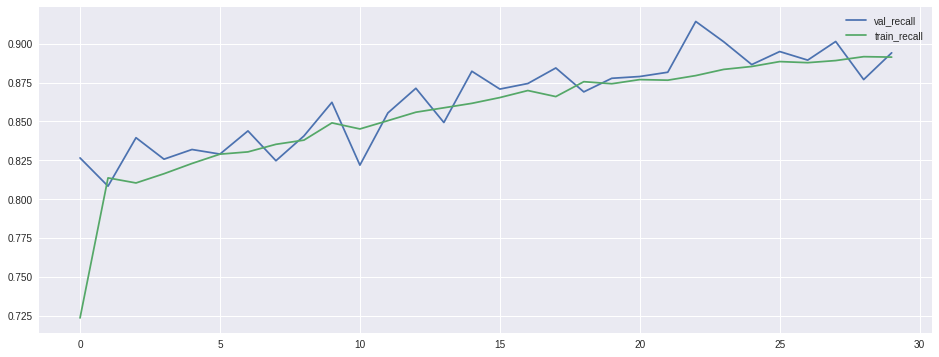

In [ ]:
plt.figure(figsize=(16,6))
plt.plot(out.history['val_recall'], label='val_recall')
plt.plot(out.history['recall'], label='train_recall')
plt.legend()

### F1 curve

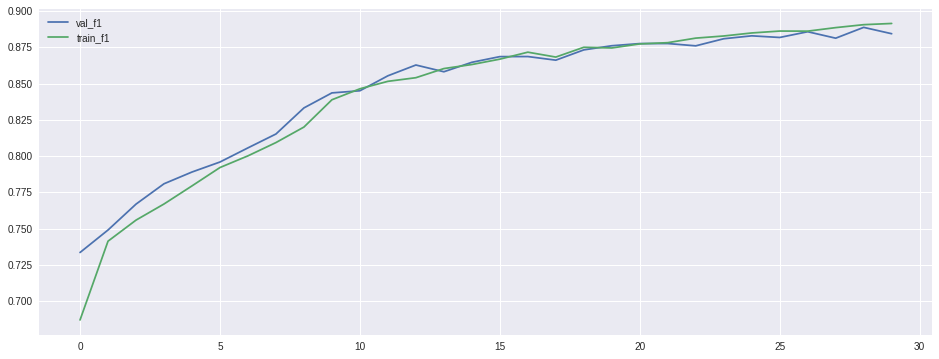

In [ ]:
plt.figure(figsize=(16,6))
plt.plot(out.history['val_f1'], label='val_f1')
plt.plot(out.history['f1'], label='train_f1')
plt.legend()

### Loss curve

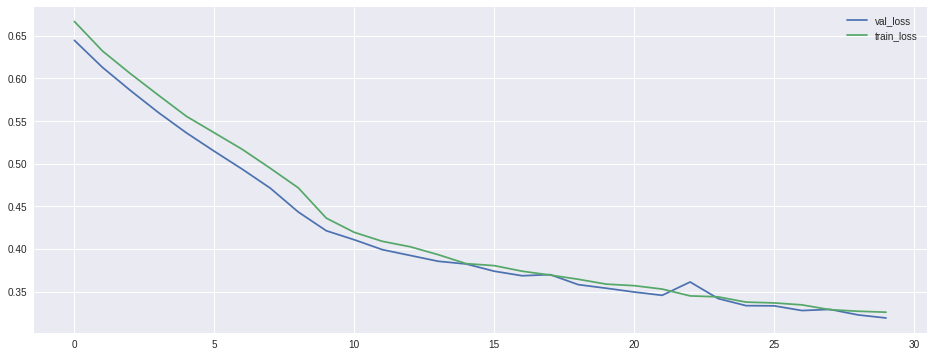

In [ ]:
plt.figure(figsize=(16,6))
plt.plot(out.history['val_loss'], label='val_loss')
plt.plot(out.history['loss'], label='train_loss')
plt.legend()

--------------------------------------------------------------------------------

In [ ]:
import pandas as pd 
data = pd.read_pickle("/content/gdrive/MyDrive/final_image_df.pkl")

### Data with 7K+ news.

In [ ]:
data.head(3)

,main_img_url,text,title,type,caps_title,caps_thread,caps_text,title_len,thread_len,text_len,excl_title,excl_thread,excl_text,first_title,first_thread,first_text,second_title,second_thread,second_text,third_title,third_thread,third_text,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,negative,positive,first_all,second_all,third_all,face_count,width,height,image_name
0,https://static01.nyt.com/images/2016/11/23/us/...,"[917, 201, 997, 1132, 13667, 637, 125, 3367, 1...","[425, 14744, 18652, 71, 10303, 30, 14538, 18, ...",0.0,0,0,0,74,1,6489,0,0,0,2,0,407,0,0,150,0,0,45,9,21,5,6,20,5,14,30,14,52,409,150,45,0.0,768.0,513.0,0
1,https://static01.nyt.com/images/2016/10/18/us/...,"[14744, 216, 18652, 71, 10303, 30, 6257, 4603,...","[18652, 6257, 14327, 414, 1286, 1183, 6099, 13...",0.0,0,0,0,75,1,2163,0,0,0,5,0,140,0,0,38,2,0,26,6,7,2,4,4,4,5,9,8,15,145,38,28,1.0,675.0,450.0,1
2,https://static01.nyt.com/images/2016/11/12/us/...,"[137, 26436, 13531, 201, 2403, 6098, 3367, 324...","[14744, 18652, 17853, 142, 266, 582, 6138, 135...",0.0,0,0,1,74,1,6239,0,0,1,4,0,436,1,0,167,1,0,67,5,19,6,8,15,8,6,26,15,34,440,168,68,0.0,768.0,508.0,2


In [ ]:
data.shape

(7272, 39)

In [ ]:
len_content = len(data['text'][0])
len_title = len(data['title'][0])

### Using glove embeddings

In [ ]:
from pathlib import Path
import numpy as np
from keras.preprocessing.text import Tokenizer

def load_glove(url):
    f = open(url.absolute())
    embeddings_index = dict()
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype="float32")
        embeddings_index[word] = coefs
    f.close()
    return embeddings_index

GLOVE_URL = Path("/content/gdrive/MyDrive/glove.6B.100d.txt")
glove = load_glove(GLOVE_URL)
t = Tokenizer()
t.fit_on_texts(glove.keys())
vocab_size = (len(t.word_index)+1)


In [ ]:
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in t.word_index.items():
    embedding_vector = glove.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
df=pd.DataFrame()
df["text"] = (pad_sequences(data["text"], maxlen=400,padding="post", truncating="post")).tolist()
df["title"] = pad_sequences(data["title"], maxlen=400,padding="post", truncating="post").tolist()

### Train-val split

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    data[['text', 'title']], data['type'], test_size=0.1, random_state=1)

In [ ]:
X_train_title = X_train['title']
X_train_content = X_train['text']

X_val_title = X_val['title']
X_val_content = X_val['text']

In [ ]:
train_fit = [np.asarray(X_train_title.tolist()), 
             np.asarray(X_train_content.tolist())]

val_fit = [np.asarray(X_val_title.tolist()), 
             np.asarray(X_val_content.tolist())]

### Trained model with the same optimal parameters

In [ ]:
title_input = k.layers.Input(shape=(len_title,))
inp = k.layers.Embedding(output_dim=100, weights=[embedding_matrix], input_dim=339252, trainable=False)(title_input)
x = k.layers.Bidirectional(k.layers.GRU(96))(inp)

#input_content
content_input = k.layers.Input(shape=(len_content,))
inp2 = k.layers.Embedding(output_dim=100, weights=[embedding_matrix], input_dim=339252, trainable=False)(content_input)
x2 = k.layers.Bidirectional(k.layers.GRU(251))(inp2)

#Merge
x = k.layers.concatenate([x, x2])

#Common part
x = k.layers.Dense(51, activation='relu')(x)
x = k.layers.Dropout(0.222)(x)
x = k.layers.Dense(25, activation='relu')(x)
x = k.layers.Dropout(0.2)(x)

out = k.layers.Dense(1, activation='sigmoid')(x)

#Build model
model = k.models.Model(inputs=[title_input, content_input], outputs=[out])

model.compile(optimizer =tf.keras.optimizers.Adam(learning_rate=0.00001,decay=0.0001),metrics=[precision,recall,f1],loss= "binary_crossentropy")

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint_path = "training_3/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
my_callbacks = [
ModelCheckpoint(checkpoint_path, monitor = 'val_loss',verbose = 1,save_weights_only=True, save_best_only = True,mode="min"),
EarlyStopping(monitor='val_loss', patience=3, verbose=0, mode='min'),
ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='min',min_delta=1e-4)
]

In [ ]:
out = model.fit(x=train_fit, y=np.asarray(y_train.tolist()), batch_size=64, epochs=30,validation_data=(val_fit, np.array(y_val.tolist())),callbacks=[my_callbacks])

Epoch 1/30
103/103 [==============================] - 57s 490ms/step - loss: 0.6719 - precision: 0.6468 - recall: 0.8769 - f1: 0.7419 - val_loss: 0.6466 - val_precision: 0.6531 - val_recall: 0.9941 - val_f1: 0.7868

Epoch 00001: val_loss improved from inf to 0.64657, saving model to training_3/cp.ckpt
Epoch 2/30
103/103 [==============================] - 49s 475ms/step - loss: 0.6477 - precision: 0.6405 - recall: 0.9609 - f1: 0.7670 - val_loss: 0.6166 - val_precision: 0.6669 - val_recall: 1.0000 - val_f1: 0.7986

Epoch 00002: val_loss improved from 0.64657 to 0.61664, saving model to training_3/cp.ckpt
Epoch 3/30
103/103 [==============================] - 49s 475ms/step - loss: 0.6174 - precision: 0.6659 - recall: 0.9805 - f1: 0.7919 - val_loss: 0.5890 - val_precision: 0.6903 - val_recall: 1.0000 - val_f1: 0.8154

Epoch 00003: val_loss improved from 0.61664 to 0.58903, saving model to training_3/cp.ckpt
Epoch 4/30
103/103 [==============================] - 49s 474ms/step - loss: 0.5922

### Saving model

In [ ]:
model.save("/content/gdrive/MyDrive/TIcnn-gru/model7k_400.h5")

### Precison curve

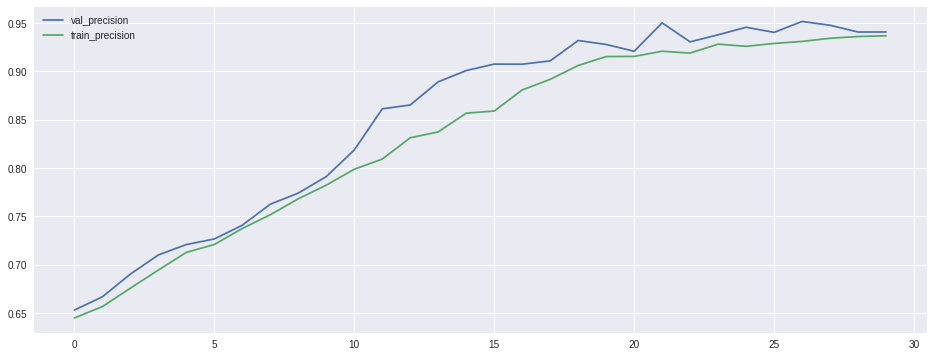

In [ ]:
plt.figure(figsize=(16,6))
plt.plot(out.history['val_precision'], label='val_precision')
plt.plot(out.history['precision'], label='train_precision')
plt.legend()

### Recall curve

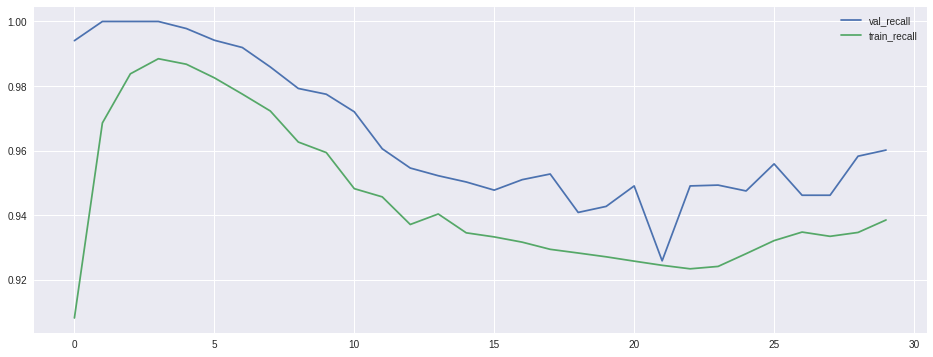

In [ ]:
plt.figure(figsize=(16,6))
plt.plot(out.history['val_recall'], label='val_recall')
plt.plot(out.history['recall'], label='train_recall')
plt.legend()

### F1-curve

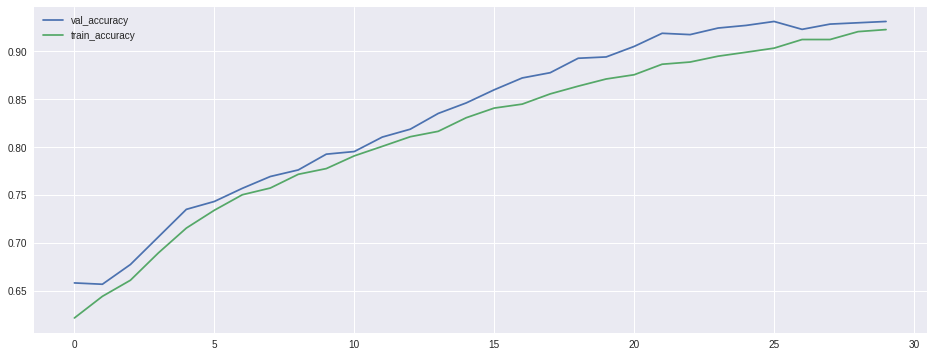

In [ ]:
plt.figure(figsize=(16,6))
plt.plot(out.history['val_f1'], label='val_f1')
plt.plot(out.history['f1'], label='train_f1')
plt.legend()

### Loss curve

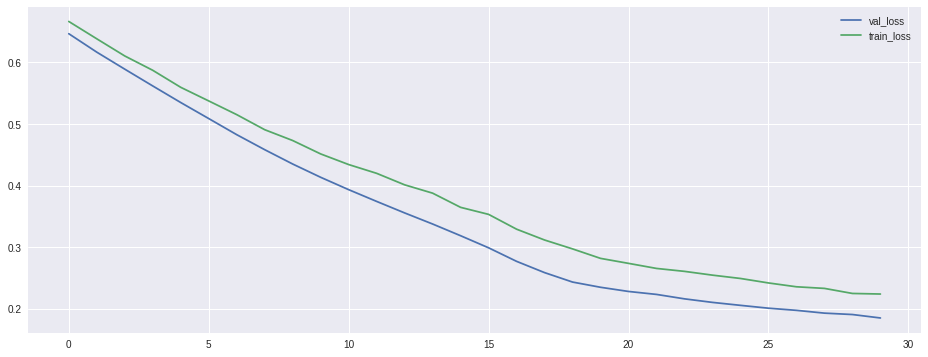

In [ ]:
plt.figure(figsize=(16,6))
plt.plot(out.history['val_loss'], label='val_loss')
plt.plot(out.history['loss'], label='train_loss')
plt.legend()